<a href="https://colab.research.google.com/github/Lashi0812/AppiledAI/blob/master/Network2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#### Libraries
# Standard library
import json
import random
import sys
import pickle
import gzip

# Third-party libraries
import numpy as np


#### Define the quadratic and cross-entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5 * np.linalg.norm(a - y) ** 2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a - y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y * np.log(a) - (1 - y) * np.log(1 - a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a - y)


#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) / np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda=0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete" % j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))
            print()
        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1 - eta * (lmbda / n)) * w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x]  # list to store all the activations, layer by layer
        zs = []  # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                       for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y) / len(data)
        cost += 0.5 * (lmbda / len(data)) * sum(
            np.linalg.norm(w) ** 2 for w in self.weights)
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()


#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net


#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e


def sigmoid(z):
    """The sigmoid function."""
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

In [9]:
def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('/content/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)


def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)


def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [13]:
training_data, validation_Data, test_data = load_data_wrapper()
net = Network([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net.SGD(
    training_data[:1000],
    400, 10, 0.5,
    evaluation_data=test_data,
    monitor_evaluation_accuracy=True,
    monitor_training_cost=True,
    monitor_evaluation_cost=True,
    monitor_training_accuracy=True)

Epoch 0 training complete
Cost on training data: 1.901582233472383
Accuracy on training data: 637 / 1000
Cost on evaluation data: 2.1660371500976354
Accuracy on evaluation data: 5572 / 10000

Epoch 1 training complete
Cost on training data: 1.488364821771823
Accuracy on training data: 733 / 1000
Cost on evaluation data: 1.880468899220692
Accuracy on evaluation data: 6204 / 10000

Epoch 2 training complete
Cost on training data: 1.1903993510534303
Accuracy on training data: 803 / 1000
Cost on evaluation data: 1.6513972923057143
Accuracy on evaluation data: 6839 / 10000

Epoch 3 training complete
Cost on training data: 0.9485569264361755
Accuracy on training data: 879 / 1000
Cost on evaluation data: 1.4491697115374789
Accuracy on evaluation data: 7396 / 10000

Epoch 4 training complete
Cost on training data: 0.8301760783428069
Accuracy on training data: 894 / 1000
Cost on evaluation data: 1.3835193272679065
Accuracy on evaluation data: 7573 / 10000

Epoch 5 training complete
Cost on trai

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use("nbagg")

<IPython.core.display.Javascript object>

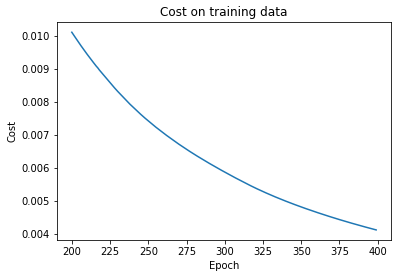

In [19]:
plt.plot(np.arange(200,400),training_cost[200:])
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Cost on training data")
plt.show()

<IPython.core.display.Javascript object>

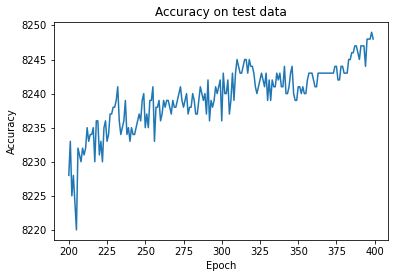

In [20]:
plt.plot(np.arange(200,400),evaluation_accuracy[200:])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy on test data")
plt.show()

<IPython.core.display.Javascript object>

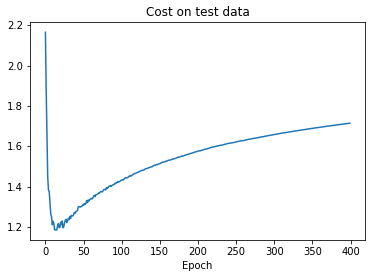

In [17]:
plt.plot(np.arange(400),evaluation_cost)
plt.xlabel("Epoch")
plt.title("Cost on test data")
plt.show()

<IPython.core.display.Javascript object>

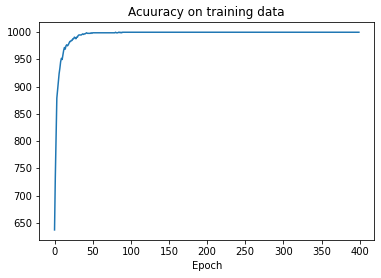

In [18]:
plt.plot(np.arange(400),training_accuracy)
plt.xlabel("Epoch")
plt.title("Acuuracy on training data")
plt.show()

In [21]:
training_data, validation_Data, test_data = load_data_wrapper()
net = Network([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net.SGD(
    training_data,
    30, 10, 0.5,
    evaluation_data=test_data,
    monitor_evaluation_accuracy=True,
    monitor_training_cost=False,
    monitor_evaluation_cost=False,
    monitor_training_accuracy=True)

Epoch 0 training complete
Accuracy on training data: 45191 / 50000
Accuracy on evaluation data: 9087 / 10000

Epoch 1 training complete
Accuracy on training data: 46400 / 50000
Accuracy on evaluation data: 9274 / 10000

Epoch 2 training complete
Accuracy on training data: 46976 / 50000
Accuracy on evaluation data: 9342 / 10000

Epoch 3 training complete
Accuracy on training data: 47126 / 50000
Accuracy on evaluation data: 9357 / 10000

Epoch 4 training complete
Accuracy on training data: 47302 / 50000
Accuracy on evaluation data: 9365 / 10000

Epoch 5 training complete
Accuracy on training data: 47558 / 50000
Accuracy on evaluation data: 9422 / 10000

Epoch 6 training complete
Accuracy on training data: 47749 / 50000
Accuracy on evaluation data: 9451 / 10000

Epoch 7 training complete
Accuracy on training data: 47875 / 50000
Accuracy on evaluation data: 9446 / 10000

Epoch 8 training complete
Accuracy on training data: 47876 / 50000
Accuracy on evaluation data: 9469 / 10000

Epoch 9 tr

<IPython.core.display.Javascript object>

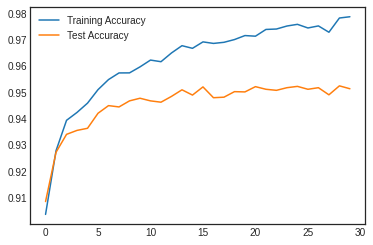

In [25]:
mpl.style.use("seaborn-white")
plt.plot(np.arange(30),np.array(training_accuracy)/50000,label="Training Accuracy")
plt.plot(np.arange(30),np.array(evaluation_accuracy)/10000,label="Test Accuracy")
plt.legend()
plt.show()

In [24]:
mpl.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [26]:
training_data, validation_Data, test_data = load_data_wrapper()
net = Network([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net.SGD(
    training_data[:1000],
    400, 10, 0.5,
    lmbda=0.1,
    evaluation_data=test_data,
    monitor_evaluation_accuracy=True,
    monitor_training_cost=True,
    monitor_evaluation_cost=True,
    monitor_training_accuracy=True)

Epoch 0 training complete
Cost on training data: 2.9458607989396164
Accuracy on training data: 674 / 1000
Cost on evaluation data: 2.248197884806606
Accuracy on evaluation data: 5755 / 10000

Epoch 1 training complete
Cost on training data: 2.4735066209172896
Accuracy on training data: 789 / 1000
Cost on evaluation data: 1.8724051507852524
Accuracy on evaluation data: 6671 / 10000

Epoch 2 training complete
Cost on training data: 2.2505582173361667
Accuracy on training data: 842 / 1000
Cost on evaluation data: 1.7311059866344827
Accuracy on evaluation data: 7027 / 10000

Epoch 3 training complete
Cost on training data: 2.0682669791817703
Accuracy on training data: 873 / 1000
Cost on evaluation data: 1.596023795259689
Accuracy on evaluation data: 7317 / 10000

Epoch 4 training complete
Cost on training data: 1.9323653693018321
Accuracy on training data: 901 / 1000
Cost on evaluation data: 1.5141287512330737
Accuracy on evaluation data: 7504 / 10000

Epoch 5 training complete
Cost on tra

<IPython.core.display.Javascript object>

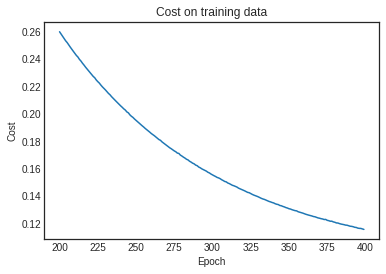

In [27]:
plt.plot(np.arange(200,400),training_cost[200:])
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Cost on training data")
plt.show()

<IPython.core.display.Javascript object>

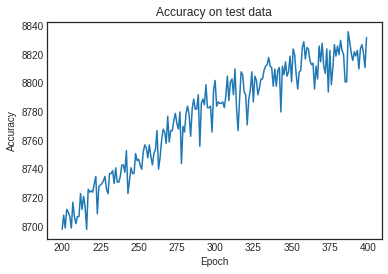

In [28]:
plt.plot(np.arange(200,400),evaluation_accuracy[200:])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy on test data")
plt.show()

<IPython.core.display.Javascript object>

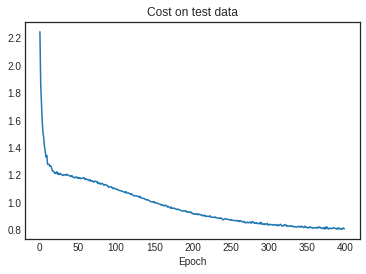

In [29]:
plt.plot(np.arange(400),evaluation_cost)
plt.xlabel("Epoch")
plt.title("Cost on test data")
plt.show()

<IPython.core.display.Javascript object>

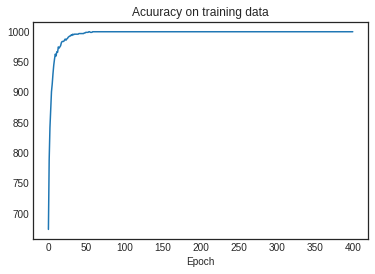

In [30]:
plt.plot(np.arange(400),training_accuracy)
plt.xlabel("Epoch")
plt.title("Acuuracy on training data")
plt.show()

In [31]:
training_data, validation_Data, test_data = load_data_wrapper()
net = Network([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net.SGD(
    training_data,
    30, 10, 0.5,
    lmbda=5.0,
    evaluation_data=test_data,
    monitor_evaluation_accuracy=True,
    monitor_training_cost=False,
    monitor_evaluation_cost=False,
    monitor_training_accuracy=True)

Epoch 0 training complete
Accuracy on training data: 45727 / 50000
Accuracy on evaluation data: 9122 / 10000

Epoch 1 training complete
Accuracy on training data: 46789 / 50000
Accuracy on evaluation data: 9327 / 10000

Epoch 2 training complete
Accuracy on training data: 47252 / 50000
Accuracy on evaluation data: 9402 / 10000

Epoch 3 training complete
Accuracy on training data: 47596 / 50000
Accuracy on evaluation data: 9454 / 10000

Epoch 4 training complete
Accuracy on training data: 47766 / 50000
Accuracy on evaluation data: 9437 / 10000

Epoch 5 training complete
Accuracy on training data: 48017 / 50000
Accuracy on evaluation data: 9506 / 10000

Epoch 6 training complete
Accuracy on training data: 48046 / 50000
Accuracy on evaluation data: 9531 / 10000

Epoch 7 training complete
Accuracy on training data: 48157 / 50000
Accuracy on evaluation data: 9535 / 10000

Epoch 8 training complete
Accuracy on training data: 48266 / 50000
Accuracy on evaluation data: 9541 / 10000

Epoch 9 tr

<IPython.core.display.Javascript object>

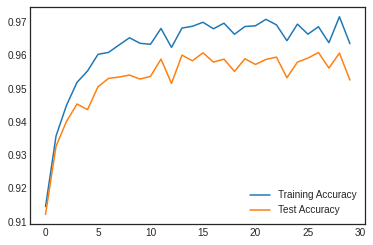

In [33]:
plt.plot(np.arange(30),np.array(training_accuracy)/50000,label="Training Accuracy")
plt.plot(np.arange(30),np.array(evaluation_accuracy)/10000,label="Test Accuracy")
plt.legend()
plt.show()

In [ ]:
n